**Environment Setup & Hugging Face Login**

In [10]:
# --- INSTALLING LIBRARIES ---

# transformers: For the core model and tokenizer.
# datasets: For efficient data handling.
# scikit-learn: For metrics, scaling, and data splitting.
# sentencepiece & sacremoses: Dependencies for back-translation models.
# accelerate: To speed up training on available hardware.
!pip install transformers[torch] datasets scikit-learn sentencepiece sacremoses accelerate -q

# --- IMPORTING LIBRARIES ---

import pandas as pd
import numpy as np
import torch
from google.colab import drive
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, pipeline
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# --- MOUNTING GOOGLE DRIVE ---

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Loading and Label Creation**

In [11]:
# --- LOADING THE DATASET ---

FILE_PATH = '/content/drive/MyDrive/Thesis 47/Saved Datasets/[Non English reviews deleted] All_Language_Data.csv'
df = pd.read_csv(FILE_PATH)

# --- DATA CLEANING ---

df.dropna(subset=['reviewText', 'originalScore'], inplace=True)

# --- DEFINING BINS AND LABELS FOR CLASSES ---

# Bins: [0, 2], (2, 4], (4, 6], (6, 8], (8, 10]
bins = [0, 2, 4, 6, 8, 10]
labels = [0, 1, 2, 3, 4]
class_names = ['Very Negative', 'Negative', 'Average', 'Positive', 'Very Positive']

# --- CREATING THE TARGET LABEL COLUMN ---


df['label'] = pd.cut(df['originalScore'], bins=bins, labels=labels, right=True, include_lowest=True)

# --- DISPLAYING CLASS DISTRIBUTION ---

print("--- Class Distribution Before Resampling ---")
print(df['label'].value_counts().sort_index())

--- Class Distribution Before Resampling ---
label
0    11436
1    40617
2    57315
3    64737
4    20696
Name: count, dtype: int64


** Upsampling with Back-Translation and Downsampling**

In [12]:
# --- FIX ---
import torch
from transformers import pipeline
from tqdm.auto import tqdm

In [13]:
from huggingface_hub import notebook_login

notebook_login()

In [18]:
# --- INITIALIZING BACK-TRANSLATION PIPELINE ---
print("Initializing back-translation models...")
device = "cuda" if torch.cuda.is_available() else "cpu"
en_to_de_translator = pipeline("translation_en_to_de", model="Helsinki-NLP/opus-mt-en-de", device=device)
de_to_en_translator = pipeline("translation_de_to_en", model="Helsinki-NLP/opus-mt-de-en", device=device)

# --- SEPARATING DATAFRAMES BY CLASS ---
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]
df_class_2 = df[df['label'] == 2]
df_class_3 = df[df['label'] == 3]
df_class_4 = df[df['label'] == 4]

# --- BATCHED UPSAMPLING ---

num_to_generate = 15000 - len(df_class_0)
samples_to_augment = df_class_0.sample(n=num_to_generate, replace=True, random_state=42)
texts_to_translate = samples_to_augment['reviewText'].tolist()

print(f"\nAugmenting {num_to_generate} samples for 'Very Negative' class using batching... (This will be quick)")

# 1. Translate all texts to German in one go (in a batch)
de_translations = en_to_de_translator(texts_to_translate, batch_size=32, truncation=True)
de_texts = [item['translation_text'] for item in de_translations]

print("...Halfway done...")

# 2. Translate all German texts back to English in one go (in a batch)
en_translations = de_to_en_translator(de_texts, batch_size=32, truncation=True)
augmented_texts = [item['translation_text'] for item in en_translations]

# 3. Create the new DataFrame with the augmented texts
df_augmented = pd.DataFrame({'reviewText': augmented_texts, 'label': 0})
df_class_0_upsampled = pd.concat([df_class_0, df_augmented])

# --- DOWNSAMPLING CLASSES 2 & 3 ---
df_class_2_downsampled = df_class_2.sample(n=40000, random_state=42)
df_class_3_downsampled = df_class_3.sample(n=45000, random_state=42)

# --- COMBINING RESAMPLED DATA ---
df_resampled = pd.concat([
    df_class_0_upsampled,
    df_class_1,  # Class 1 was not changed
    df_class_2_downsampled,
    df_class_3_downsampled,
    df_class_4   # Class 4 was not changed
])

# --- DISPLAYING NEW CLASS DISTRIBUTION ---
print("\n--- Class Distribution After Resampling ---")
print(df_resampled['label'].value_counts().sort_index())

Initializing back-translation models...


Device set to use cuda
Device set to use cuda



Augmenting 3564 samples for 'Very Negative' class using batching... (This will be quick)
...Halfway done...

--- Class Distribution After Resampling ---
label
0    15000
1    40617
2    40000
3    45000
4    20696
Name: count, dtype: int64


**Tokenization and Dataset Preparation**

In [19]:
# --- MODEL AND TOKENIZER SETUP ---

MODEL_CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

# --- PREPARING DATA FOR HUGGING FACE ---

train_df, test_df = train_test_split(df_resampled[['reviewText', 'label']], test_size=0.2, random_state=42, stratify=df_resampled['label'])
raw_datasets = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'test': Dataset.from_pandas(test_df)
})

# --- TOKENIZATION FUNCTION ---
# A function that tokenizes a batch of review texts.
# padding='max_length' ensures all inputs are the same size.
# truncation=True cuts off reviews that are too long.
def tokenize_function(examples):
    return tokenizer(examples["reviewText"], padding="max_length", truncation=True, max_length=256)

# --- APPLYING TOKENIZATION ---
# Applies the tokenization function to the entire dataset.
# The `map` function is highly efficient and shows a progress bar automatically.
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# --- REMOVING UNNECESSARY COLUMNS ---
# Removes the original text and __index_level_0__ columns as they are no longer needed after tokenization.
tokenized_datasets = tokenized_datasets.remove_columns(["reviewText", "__index_level_0__"])
tokenized_datasets.set_format("torch")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/129050 [00:00<?, ? examples/s]

Map:   0%|          | 0/32263 [00:00<?, ? examples/s]

**Training the Model**

In [21]:
# --- MODEL INITIALIZATION ---
# Loads the DistilBERT model with a classification head for 5 labels.
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=5,
    id2label={i: name for i, name in enumerate(class_names)},
    label2id={name: i for i, name in enumerate(class_names)}
)

# --- EVALUATION METRICS FUNCTION ---
# Defines a function to compute metrics (accuracy, F1, precision, recall) during evaluation.
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# --- DEFINING TRAINING ARGUMENTS ---
# Sets up all the hyperparameters and settings for the training process.
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/THESIS 47/Saved Datasets/results_text_only",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False, # Set to True if you want to upload to Hugging Face Hub
)

# --- INITIALIZING THE TRAINER ---
# Creates the Trainer instance, which handles the entire training and evaluation loop.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# --- STARTING THE TRAINING ---
# This command starts the fine-tuning process. Progress will be displayed below.
print("\n--- Starting Training for Text-Only Model ---")
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2136733081.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Starting Training for Text-Only Model ---


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rafid2542 (rafid2542-ahsanullah-university-of-science-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.132300,1.114639,0.498652,0.486804,0.498172,0.498652
2,1.005300,1.101886,0.509562,0.502957,0.513886,0.509562
3,0.867500,1.156360,0.508384,0.506359,0.508713,0.508384


TrainOutput(global_step=24198, training_loss=1.0298743102558192, metrics={'train_runtime': 9133.1139, 'train_samples_per_second': 42.39, 'train_steps_per_second': 2.649, 'total_flos': 2.5643748580992e+16, 'train_loss': 1.0298743102558192, 'epoch': 3.0})

**Evaluation and Visualization**

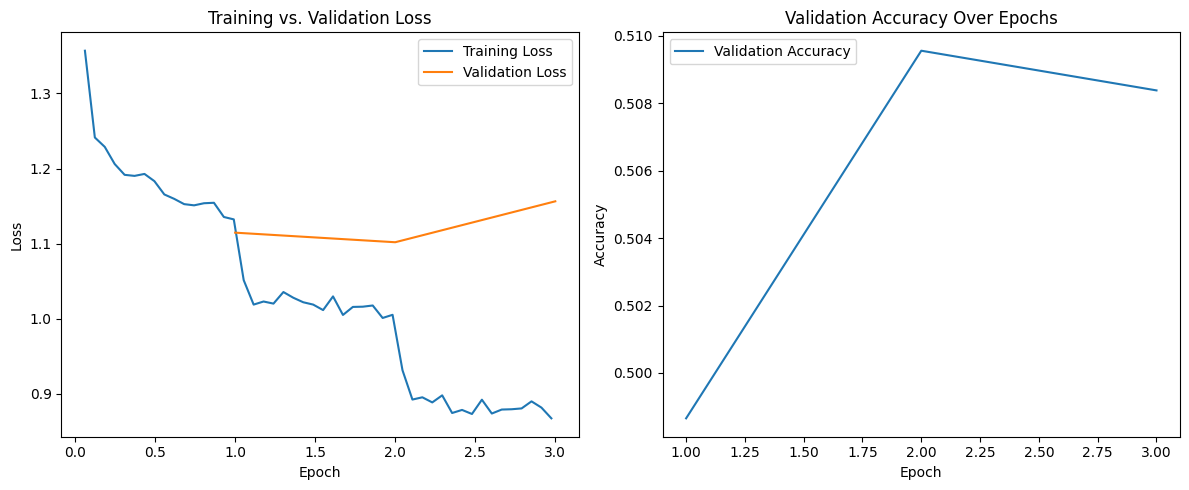


--- Final Evaluation on Test Set ---


{'eval_loss': 1.1018860340118408, 'eval_accuracy': 0.5095620370083377, 'eval_f1': 0.5029571521393452, 'eval_precision': 0.5138860532737708, 'eval_recall': 0.5095620370083377, 'eval_runtime': 234.7172, 'eval_samples_per_second': 137.455, 'eval_steps_per_second': 8.593, 'epoch': 3.0}

--- Classification Report ---
               precision    recall  f1-score   support

Very Negative       0.58      0.36      0.44      3000
     Negative       0.48      0.65      0.55      8124
      Average       0.44      0.37      0.40      8000
     Positive       0.55      0.60      0.57      9000
Very Positive       0.59      0.42      0.49      4139

     accuracy                           0.51     32263
    macro avg       0.53      0.48      0.49     32263
 weighted avg       0.51      0.51      0.50     32263



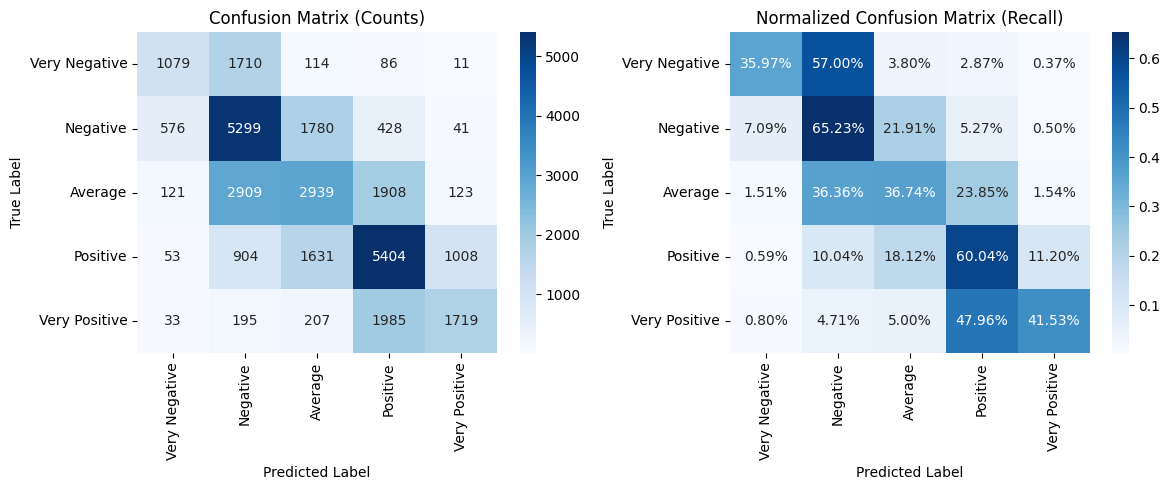

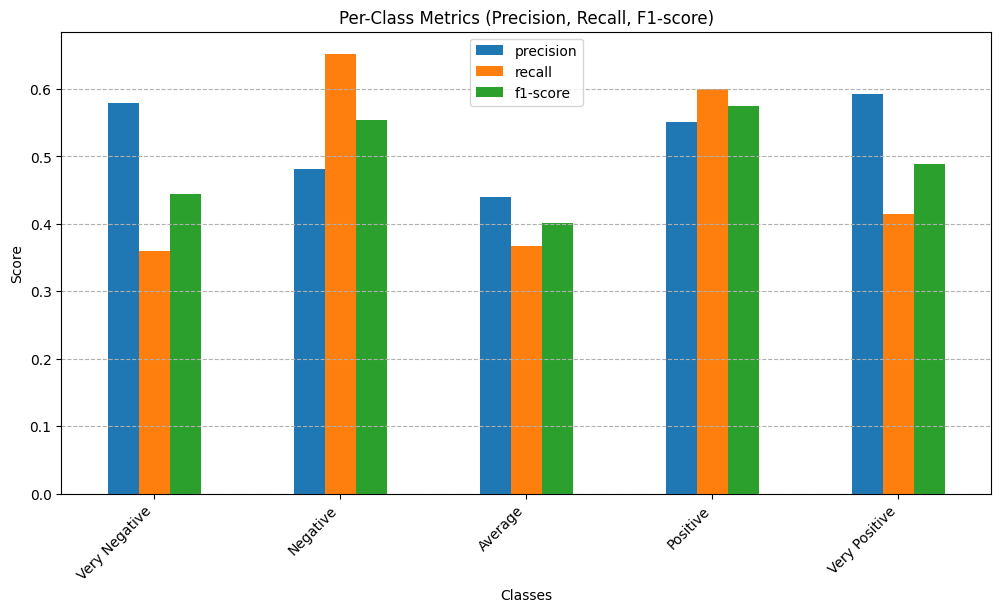


Model saved to /content/drive/MyDrive/THESIS 47/Saved Datasets/fine-tuned-text-only-model


In [22]:
# --- EXTRACTING TRAINING HISTORY ---
# The trainer's log history contains the loss and metrics from training and validation.
log_history = trainer.state.log_history

# Separate training and validation logs
train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

# --- 1. PLOTTING TRAINING VS VALIDATION LOSS ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([log['epoch'] for log in train_logs], [log['loss'] for log in train_logs], label='Training Loss')
plt.plot([log['epoch'] for log in eval_logs], [log['eval_loss'] for log in eval_logs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# --- 2. PLOTTING TRAINING VS VALIDATION ACCURACY ---
plt.subplot(1, 2, 2)
plt.plot([log['epoch'] for log in eval_logs], [log['eval_accuracy'] for log in eval_logs], label='Validation Accuracy')
# You can also plot training accuracy if you log it during training
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()


# --- FINAL EVALUATION ON TEST SET ---
print("\n--- Final Evaluation on Test Set ---")
eval_results = trainer.evaluate()
print(eval_results)


# --- GENERATING PREDICTIONS ---
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = tokenized_datasets["test"]["label"]


# --- 3. CLASSIFICATION REPORT ---
print("\n--- Classification Report ---")
report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
print(classification_report(true_labels, predicted_labels, target_names=class_names))


# --- 4. CONFUSION MATRIX (RAW COUNTS) ---
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Counts)')


# --- 5. NORMALIZED CONFUSION MATRIX (RECALL/PERCENTAGES) ---
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Recall)')
plt.tight_layout()
plt.show()


# --- 6. PER-CLASS METRICS BAR CHART ---
report_df = pd.DataFrame(report).transpose()
# Drop the support, accuracy, and weighted avg rows for a cleaner plot
metrics_df = report_df.loc[class_names]
metrics_df.plot(kind='bar', y=['precision', 'recall', 'f1-score'], figsize=(12, 6))
plt.title('Per-Class Metrics (Precision, Recall, F1-score)')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.show()


# --- SAVING THE MODEL ---
output_model_path = "/content/drive/MyDrive/THESIS 47/Saved Datasets/fine-tuned-text-only-model"
trainer.save_model(output_model_path)
print(f"\nModel saved to {output_model_path}")